In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import json
from datasets import Dataset


In [3]:
import json

with open("drive/MyDrive/biology_finetune/double_questions_dataset.json", "r", encoding="utf-8") as f:
    data = json.load(f)

print("Total questions:", len(data))


Total questions: 2772


# Preparing the dataset

In [1]:
import json
import os

# === INPUT AND OUTPUT FILES ===
input_file = "drive/MyDrive/biology_finetune/double_questions_dataset.json"
output_file = "double_questions_dataset_no_prompt.json"

# === LOAD DATASET ===
try:
    with open(input_file, "r", encoding="utf-8") as f:
        data = json.load(f)
    print(f"Loaded: {len(data)} items from {input_file}")
except FileNotFoundError:
    print(f"Error: Could not find {input_file}. Please check the file path.")
    data = []

rewritten = []

for item in data:
    q = item.get("question", "").strip()
    if not q:
        continue

    a1 = item.get("answer1", "").strip()
    a2 = item.get("answer2", "").strip()
    a3 = item.get("answer3", "").strip()

    # SHORT ANSWER 1
    if a1:
        rewritten.append({
            "messages": [
                {"role": "user", "content": q},
                {"role": "assistant", "content": a1}
            ]
        })

    # SHORT ANSWER 2
    if a2:
        rewritten.append({
            "messages": [
                {"role": "user", "content": q},
                {"role": "assistant", "content": a2}
            ]
        })

    # COT ANSWER 3
    if a3:
        rewritten.append({
            "messages": [
                {"role": "user", "content": q},
                {"role": "assistant", "content": a3}
            ]
        })

print(f"Final dataset rows: {len(rewritten)}")

# === SAVE OUTPUT ===
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(rewritten, f, ensure_ascii=False, indent=2)

print(f"Saved to: {output_file}")


Loaded: 2772 items from drive/MyDrive/biology_finetune/double_questions_dataset.json
Final dataset rows: 8316
Saved to: double_questions_dataset_no_prompt.json


In [13]:
import json
import os

# === INPUT AND OUTPUT FILES ===
# Make sure this filename matches exactly what you uploaded
input_file = "drive/MyDrive/biology_finetune/double_questions_dataset.json"
output_file = "double_questions_dataset_with_system_prompt.json"

# === SYSTEM PROMPTS ===
# Prompt for Short/Standard Answers (Answer 1 & 2)
system_short = (
    "Sen bir biyoloji asistanısın. Soruyu açık, anlaşılır ve orta uzunlukta bir açıklamayla cevapla. "
    "Gereksiz ayrıntılara girme, mantık adımlarını veya çözüm sürecini açıkça göstermeden "
    "sonuç odaklı ve öğretici bir yanıt üret. "
    "Yanıtın doğal, akıcı ve bilgilendirici olmasına dikkat et."
)

# Prompt for Chain of Thought Answers (Answer 3)
system_cot = (
    "Sen uzman bir biyoloji öğretmenisin. Soruyu adım adım düşünerek cevapla. "
    "Önce problemi analiz et, ardından mantıklı bir akış içinde gerekçeleri sırala ve "
    "her adımda neden-sonuç ilişkisini açıkla. "
    "En sonunda ise net ve güçlü bir sonuç paragrafı yaz."
)

# === LOAD DATASET ===
try:
    with open(input_file, "r", encoding="utf-8") as f:
        data = json.load(f)
    print(f"Loaded: {len(data)} items from {input_file}")
except FileNotFoundError:
    print(f"Error: Could not find {input_file}. Please check the file path.")
    data = []

rewritten = []

for item in data:
    q = item.get("question", "").strip()

    # Skip if question is missing
    if not q:
        continue

    # Extract answers safely
    a1 = item.get("answer1", "").strip()
    a2 = item.get("answer2", "").strip()
    a3 = item.get("answer3", "").strip()

    # --- SHORT ANSWER 1 (Only add if answer exists) ---
    if a1:
        rewritten.append({
            "messages": [
                {"role": "system", "content": system_short},
                {"role": "user", "content": q},
                {"role": "assistant", "content": a1}
            ]
        })

    # --- SHORT ANSWER 2 (Only add if answer exists) ---
    if a2:
        rewritten.append({
            "messages": [
                {"role": "system", "content": system_short},
                {"role": "user", "content": q},
                {"role": "assistant", "content": a2}
            ]
        })

    # --- COT ANSWER 3 (Only add if answer exists) ---
    if a3:
        rewritten.append({
            "messages": [
                {"role": "system", "content": system_cot},
                {"role": "user", "content": q},
                {"role": "assistant", "content": a3}
            ]
        })

print(f"Final dataset rows: {len(rewritten)}")

# === SAVE OUTPUT ===
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(rewritten, f, ensure_ascii=False, indent=2)

print(f"Saved to: {output_file}")

Loaded: 2772 items from drive/MyDrive/biology_finetune/double_questions_dataset.json
Final dataset rows: 8316
Saved to: double_questions_dataset_with_system_prompt.json


In [2]:
pip install transformers accelerate datasets peft trl bitsandbytes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 44.7 MB/s eta 0:00:00


# Training

In [10]:
import json
from datasets import load_dataset

# === INPUT AND OUTPUT PATHS ===
input_path = "/content/drive/MyDrive/biology_finetune/double_questions_dataset_no_prompt.json"
output_path = "/content/drive/MyDrive/biology_finetune/double_questions_dataset_no_prompt_final.json"

# === LOAD DATASET ===
ds = load_dataset(
    "json",
    data_files=input_path,
)["train"]

print("Loaded samples:", len(ds))

# === SHUFFLE ===
ds = ds.shuffle(seed=42)

print("Shuffled samples:", len(ds))

# === SAVE AS HUMAN-READABLE JSONL (UTF-8, NO ESCAPED CHARACTERS) ===
with open(output_path, "w", encoding="utf-8") as f:
    for item in ds:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

print("Saved human-readable shuffled file to:", output_path)


Generating train split: 0 examples [00:00, ? examples/s]

Loaded samples: 8316
Shuffled samples: 8316
Saved human-readable shuffled file to: /content/drive/MyDrive/biology_finetune/double_questions_dataset_no_prompt_final.json


In [1]:
from datasets import load_dataset
data_file = "/content/drive/MyDrive/biology_finetune/double_questions_dataset_no_prompt_final.json"
# Load your full dataset
dataset = load_dataset("json", data_files=data_file)

# dataset is now {"train": Dataset(...)} because it's a single file
full_ds = dataset["train"]

# Create train / validation / test splits
split_ds = full_ds.train_test_split(test_size=0.10, seed=42)  # 10% test
temp_train = split_ds["train"]

split_val = temp_train.train_test_split(test_size=0.055, seed=42)
# ~5% validation (5.5% of 90% ≈ 5%)

train_ds = split_val["train"]
val_ds   = split_val["test"]
test_ds  = split_ds["test"]

print("Train samples:", len(train_ds))
print("Validation samples:", len(val_ds))
print("Test samples:", len(test_ds))


Train samples: 7072
Validation samples: 412
Test samples: 832


In [3]:
trainer.train()


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Step,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.74 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.74 GiB is free. Process 46470 has 11.99 GiB memory in use. Of the allocated memory 8.76 GiB is allocated by PyTorch, and 3.10 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [2]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import LoraConfig
from trl import SFTConfig, SFTTrainer
import inspect

# 1. Disable external logging tools
os.environ["WANDB_DISABLED"] = "true"

model_name = "Qwen/Qwen2.5-1.5B"

# 2. Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer.padding_side = "right"

# 3. Load Model (A100 Optimized)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.bfloat16,        # bfloat16 is best for A100
)

# 4. Define Config with REPORT_TO FIX
sft_config = SFTConfig(
    output_dir="/content/drive/MyDrive/biology_finetune/second_model_double_questions",
    max_length=2048,
    dataset_text_field="text",
    packing=False,
    logging_strategy="steps",
    logging_first_step=True,
    num_train_epochs=5,
    per_device_train_batch_size=4,  # Increased to 4 (A100 handles this easily)
    gradient_accumulation_steps=2,  # Adjusted to keep effective batch size = 8
    learning_rate=2e-4,
    bf16=True,
    logging_steps=50,
    save_steps=500,
    save_total_limit=50,
    eval_strategy="steps",      # <--- REQUIRED: Turn on validation
    eval_steps=30,              # <--- REQUIRED: Test model every 30 steps
    do_eval=True,

    # --- THE FIX FOR YOUR EMPTY TABLE ---
    report_to="none",
    # ------------------------------------
)

# 5. Define LoRA
lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)

# 6. Create Trainer
trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=tokenizer,
    peft_config=lora_config,
)



`torch_dtype` is deprecated! Use `dtype` instead!


Tokenizing train dataset:   0%|          | 0/7072 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/7072 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/412 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/412 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


## Comparison

In [ ]:
from peft import PeftModel
from transformers import pipeline

ft_model = PeftModel.from_pretrained(
    model,
    "/content/drive/MyDrive/biology_finetune/biology_lora/checkpoint-13260"
)

pipe = pipeline(
    "text-generation",
    model=ft_model,
    tokenizer=tokenizer,
    max_new_tokens=200
)

print(pipe("Soru: Asit-baz kimyası biyokimyada neden önemlidir?")[0]["generated_text"])


AttributeError: 'str' object has no attribute 'named_modules'

In [ ]:
question = "Asit-baz kimyası biyokimyada neden önemlidir?"
prompt = f"Soru: {question}\nCevap:"

print(pipe(prompt)[0]["generated_text"])


Soru: Asit-baz kimyası biyokimyada neden önemlidir?
Cevap: Asit-baz kimyası, biyokimyada önemli bir rol oynamaktadır. Bu kimyası, biyolojik moleküllerin üretimi, temizlik ve örtelik sistemlerin çalışması için ana bir kimya kaynağıdır. Asit-baz kimyası, biyolojik moleküllerin üretimi için temel bir kimya kaynağıdır.


In [ ]:
def make_prompt(title, question):
    return f"""
Bu soruya dair gerekli bağlamı ve arka plan bilgisini kendi bilginize dayanarak analiz edin.
Mantıklı sonuçlara ulaşmak için düşünce zincirini kullanarak adım adım ilerleyin ve sonunda sorunun nihai cevabını verin.

Soru:
{question}

Çözüm süreciniz:
- biyoloji/bilim bilginize dayansın.
- Adım adım, mantıklı ve tutarlı bir düşünce zinciri içersin.
- Gereksiz tekrar veya gereksiz uzatma olmadan en önemli noktaları vurgulasın.

Lütfen önce düşünce zincirini, ardından nihai cevabı verin.
"""


In [ ]:
title = "Asit-baz kimyası ve biyokimyadaki rolü"
question = "Asit-baz kimyası biyokimyada neden önemlidir?"

prompt = make_prompt(title, question)
print(pipe(prompt)[0]["generated_text"])



Bu soruya dair gerekli bağlamı ve arka plan bilgisini kendi bilginize dayanarak analiz edin.
Mantıklı sonuçlara ulaşmak için düşünce zincirini kullanarak adım adım ilerleyin ve sonunda sorunun nihai cevabını verin.

Soru:
Asit-baz kimyası biyokimyada neden önemlidir?

Çözüm süreciniz:
- biyoloji/bilim bilginize dayansın.
- Adım adım, mantıklı ve tutarlı bir düşünce zinciri içersin.
- Gereksiz tekrar veya gereksiz uzatma olmadan en önemli noktaları vurgulasın.

Lütfen önce düşünce zincirini, ardından nihai cevabı verin.
Mantıklı sonuçlara ulaşmak için, adımları adım adım ilerleyin ve sonunda sorunun nihai cevabını verin.


In [ ]:
import os
os.environ["WANDB_MODE"] = "disabled"


In [ ]:
!pip uninstall -y wandb


Found existing installation: wandb 0.23.0
Uninstalling wandb-0.23.0:
  Successfully uninstalled wandb-0.23.0


### Comparison between baseline and final checkpoin

In [ ]:
EVAL_QUESTION = "Soru: Asit-baz kimyası biyokimyada neden önemlidir?\nCevap:"


In [ ]:
model_name = "Qwen/Qwen2.5-1.5B"

In [ ]:
from transformers import pipeline

baseline_pipe = pipeline(
    "text-generation",
    model=model_name,        # your original Qwen model
    tokenizer=tokenizer,
    max_new_tokens=200
)

print("===== BASELINE MODEL =====")
print(baseline_pipe(EVAL_QUESTION)[0]["generated_text"])


Device set to use cuda:0


===== BASELINE MODEL =====
Soru: Asit-baz kimyası biyokimyada neden önemlidir?
Cevap: Asit-baz kimyası biyokimyada önemli bir rol oynamaktadır. Bu kimyasılarda, inşaat ve construction projelerindeki biyokimya ürünlerinin üretiminde kayda değer yer alır. Ayrıca, farklı inşaat projelerini desteklemek için kullanılan kimyasılarda da asit-baz kimiyasların kullanılması önemlidir.


In [10]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from peft import PeftModel

base_model_name = "Qwen/Qwen2.5-1.5B"

# 1. Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# 2. Load BASE model (required before PEFT model)
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    torch_dtype="auto",
    device_map="auto"
)

# 3. Path to your LoRA checkpoint
mid_ckpt = "/content/drive/MyDrive/biology_finetune/second_model_double_questions/checkpoint-2500"

# 4. Load LoRA weights on top of the base model
mid_model = PeftModel.from_pretrained(
    base_model,
    mid_ckpt
)
mid_pipe = pipeline(
    "text-generation",
    model=mid_model,
    tokenizer=tokenizer
)


print(mid_pipe(prompt)[0]["generated_text"])


Device set to use cuda:0


IndexError: list index out of range

In [16]:

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from peft import PeftModel

base_model_name = "Qwen/Qwen2.5-1.5B"

tokenizer = AutoTokenizer.from_pretrained(base_model_name)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    torch_dtype="auto",
    device_map="auto"
)

mid_ckpt = "/content/drive/MyDrive/biology_finetune/second_model_double_questions/checkpoint-2500"

mid_model = PeftModel.from_pretrained(
    base_model,
    mid_ckpt
)

mid_pipe = pipeline(
    "text-generation",
    model=mid_model,
    tokenizer=tokenizer
)

prompt = (
    "Soru: Canlılık vasıflarından bazıları, cansız maddelerde ne tür benzerlikler gösterebilir?soruya acik ve cok detayi vermeden cevap ver"

    "Cevap:\n\n"
)

print(mid_pipe(prompt, max_new_tokens=200, temperature=0.3)[0]["generated_text"])


Device set to use cuda:0


Soru: Canlılık vasıflarından bazıları, cansız maddelerde ne tür benzerlikler gösterebilir?soruya acik ve cok detayi vermeden cevap verCevap:

Canlılık özelliklerinin bazıları canlılara özgüdür, ancak bazıları cansız maddelere özgüdür. Bu özellikler, canlıların farklı yaşam formlarını ve davranışlarını belirler. Canlılık özelliklerinin çoğu, hücrelerin varlığı, metabolizma, homeostaz, evrim, yaşamanın başlangıcı, organizasyon, kimya, enerji, evrim, genetik bilgi depolama, aktarım ve aktarımıza ihtiyaç, çevresini algılama, tepkiler verme ve davranışsal davranışlar gibi özelliklerden oluşur. Bu özellikler, canlıların yaşamı için hayati öneme sahiptir ve onları diğer organizmalarından ayırmazlar. Canlılık özelliklerinin çoğu, canlıların yaşam formlarını ve davranışlarını belirler. Bu özellikler, canlıların farklı yaşam formlarını


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from peft import PeftModel

base_model_name = "Qwen/Qwen2.5-1.5B"

# 1. Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# 2. Load BASE model (required before PEFT model)
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    torch_dtype="auto",
    device_map="auto"
)

# 3. Path to your LoRA checkpoint
mid_ckpt = "/content/drive/MyDrive/biology_finetune/biology_lora/checkpoint-4000"

# 4. Load LoRA weights on top of the base model
mid_model = PeftModel.from_pretrained(
    base_model,
    mid_ckpt
)
mid_pipe = pipeline(
    "text-generation",
    model=mid_model,
    tokenizer=tokenizer)

prompt = "Asit-baz dengesi biyokimyada neden önemlidir? Soruya acik ve anlasilir bir sekilde, ogretici ve sonuc odakli bir cevap ver. Cevap orta uzunlukta, akici ve bilgilendirici olsun. Gereksiz ayrintilara girme."

print(mid_pipe(prompt)[0]["generated_text"])


Device set to use cuda:0
The model 'PeftModel' is not supported for text-generation. Supported models are ['PeftModelForCausalLM', 'ApertusForCausalLM', 'ArceeForCausalLM', 'AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BitNetForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'BltForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV2ForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'DogeForCausalLM', 'Dots1ForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'Ernie4_5ForCausalLM', 'Ernie4_5_MoeForCausalLM', 'Exaone4ForCausalLM', 'FalconForCausalLM', 'FalconH1ForCausalLM', 'FalconMambaForCausalLM', 'FlexOlmoForCausalLM', '

Asit-baz dengesi biyokimyada neden önemlidir? Soruya acik ve anlasilir bir sekilde, ogretici ve sonuc odakli bir cevap ver. Cevap orta uzunlukta, akici ve bilgilendirici olsun. Gereksiz ayrintilara girme. Asit-baz dengesinin biyokimyada önemini açıklarken, biyoloji bilgilerini uygun bir şekilde kullanabilir misiniz?

Asit-baz dengesinin biyokimyada önemini anlamak için, biyoteknoloji ve biyokimyada önemli olan biyoteknik alanlarında neden önemlidir hakkında daha ayrıntı alabiliriz.

1. **İnsan Genotipi**: Asit-baz dengesini anlamak için, insan üreme deneyleri için kullanılan genetik testleri yapmak önemlidir. Bu testler, insan üreme gücünün hangi genlerle başlangıçta birbirine bağlı olduğunu belirlemek için kullanılır. Bu, insanın üreme potansiyelini değerlendirmek için gerekli bilgiye sahiptir.

2. **Genetik Çeşitlilik**: İnsanlar tek bir birim olarak varırlar ve genetik çeşitlilik inanılmaz derecede yüksek. Bu, insan için oldukça kolay bir biyokimye kavuşturmak için gereksinim


In [ ]:
SYSTEM_A = """
Soruyu açık, anlaşılır ve orta uzunlukta bir açıklamayla cevapla.
Gereksiz ayrıntılara girme. Mantık adımlarını göstermeden,
sonuç odaklı ve öğretici bir yanıt üret.
"""

SYSTEM_B = """
Soruyu adım adım düşünerek cevapla.
Önce problemi analiz et, ardından mantıklı bir akış içinde gerekçeleri sırala,
her adımda neden-sonuç ilişkisini açıkla.
En sonunda ise net bir sonuç paragrafı yaz.
"""
def build_prompt(system_prompt, user_question):
    return (
        f"{system_prompt.strip()}\n\n"
        f"Kullanıcı: {user_question.strip()}\n"
        f"Asistan:"
    )


In [ ]:
def generate(question, mode="A",
             temperature=0.3,
             top_p=0.95,
             max_new_tokens=200):

    # Select system prompt
    if mode.upper() == "A":
        system_prompt = SYSTEM_A
    elif mode.upper() == "B":
        system_prompt = SYSTEM_B
    else:
        raise ValueError("Mode must be 'A' or 'B'")

    # Build formatted prompt
    prompt = build_prompt(system_prompt, question)

    # Run generation
    output = final_pipe(
        prompt,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_p=top_p,
        do_sample=True
    )[0]["generated_text"]

    # Remove the prompt part → return only the assistant answer
    if "Asistan:" in output:
        output = output.split("Asistan:", 1)[1].strip()

    return output


In [ ]:
from peft import PeftModel

final_ckpt = "/content/drive/MyDrive/biology_finetune/biology_lora/checkpoint-4000"

final_model = PeftModel.from_pretrained(model, final_ckpt)

final_pipe = pipeline(
    "text-generation",
    model=final_model,
    tokenizer=tokenizer,
)

print("===== FINAL CHECKPOINT =====")
print(final_pipe(EVAL_QUESTION)[0]["generated_text"])


AttributeError: 'str' object has no attribute 'named_modules'

In [ ]:
final_ckpt = "/content/drive/MyDrive/biology_finetune/biology_lora/checkpoint-4000"

final_model = PeftModel.from_pretrained(model, final_ckpt)

final_pipe = pipeline(
    "text-generation",
    model=final_model,
    tokenizer=tokenizer,
)

print("===== FINAL CHECKPOINT =====")
print(generate(EVAL_QUESTION, mode="B"))




Device set to use cuda:0
The model 'PeftModel' is not supported for text-generation. Supported models are ['PeftModelForCausalLM', 'ApertusForCausalLM', 'ArceeForCausalLM', 'AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BitNetForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'BltForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV2ForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'DogeForCausalLM', 'Dots1ForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'Ernie4_5ForCausalLM', 'Ernie4_5_MoeForCausalLM', 'Exaone4ForCausalLM', 'FalconForCausalLM', 'FalconH1ForCausalLM', 'FalconMambaForCausalLM', 'FlexOlmoForCausalLM', '

===== FINAL CHECKPOINT =====
Soruyu adım adım düşünerek cevapla.

1. **Temel Kavramlar ve Bilgiler**: İlk olarak, asit-baz kimyasının ne olduğunu anlamak önemlidir. Asit-baz kimya, moleküllerin kimyasal yapısını ve reaksiyonlarını açıklamak için kullanılan bir bilimsel modeldir. Bu bilgi, asit-baz kimyasının temel yapısını ve rolünü anlamamıza yardımcı olur.

2. **Asit-Baz Kimyasının Rolü**: Asit-baz kimyasının, hücrelerin biyokimyasal reaksiyonları ve kimyasal yapısını nasıl etkilediğini anlamak önemlidir. Bu bilgi, asit-baz kimyasının biyokimyadaki öneminin belirlenmesini sağlar.

3. **Biyokimyasal Reaksiyon


In [ ]:
pip install transformers accelerate sentencepiece


In [ ]:
def make_prompt(title, question):
    return f"""
Bu soruya dair gerekli bağlamı ve arka plan bilgisini kendi bilginize dayanarak analiz edin.
Mantıklı sonuçlara ulaşmak için düşünce zincirini kullanarak adım adım ilerleyin ve sonunda sorunun nihai cevabını verin.

Soru:
{question}

Çözüm süreciniz:
- biyoloji/bilim bilginize dayansın.
- Adım adım, mantıklı ve tutarlı bir düşünce zinciri içersin.
- Gereksiz tekrar veya gereksiz uzatma olmadan en önemli noktaları vurgulasın.

Lütfen önce düşünce zincirini, ardından nihai cevabı verin.
"""

"""


In [ ]:
def generate_custom(prompt,
                    temperature=0.3,
                    top_p=0.95,
                    max_new_tokens=200):

    result = final_pipe(
        prompt,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_p=top_p,
        do_sample=True
    )[0]["generated_text"]

    return result


In [ ]:
def generate_custom(prompt, **kwargs):
    full = final_pipe(prompt, **kwargs)[0]["generated_text"]
    return full.replace(prompt, "").strip()


In [ ]:
import json
import matplotlib.pyplot as plt

state_path = "/content/drive/MyDrive/biology_finetune/biology_lora/checkpoint-13260/trainer_state.json"

with open(state_path, "r") as f:
    state = json.load(f)

log_history = state["log_history"]


In [ ]:
train_steps = []
train_loss = []

val_steps = []
val_loss = []

for entry in log_history:
    if "loss" in entry and "eval_loss" not in entry:   # training loss
        train_steps.append(entry["step"])
        train_loss.append(entry["loss"])

    if "eval_loss" in entry:                           # validation loss
        val_steps.append(entry["step"])
        val_loss.append(entry["eval_loss"])


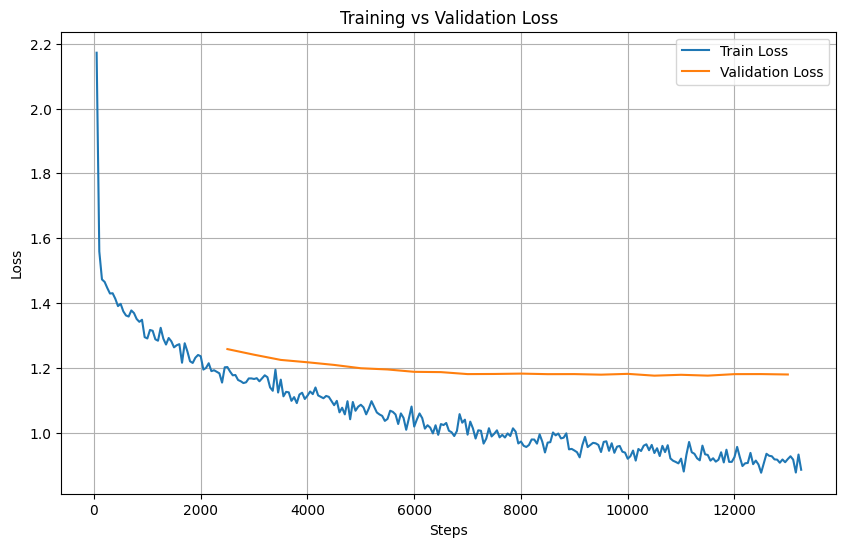

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_steps, train_loss, label="Train Loss")
plt.plot(val_steps, val_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()
